# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import tensorflow as tf

print("Versão do TensorFlow:", tf.__version__)
print("GPUs disponíveis:")
print(tf.config.experimental.list_physical_devices('GPU'))

2024-10-21 02:02:39.629713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Versão do TensorFlow: 2.4.1
GPUs disponíveis:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-21 02:02:41.289549: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-21 02:02:41.290682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-21 02:02:41.395791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-21 02:02:41.398621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.57GiB deviceMemoryBandwidth: 298.08GiB/s
2024-10-21 02:02:41.398709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-10-21 02:02:41.442697: I tensorflow/stream_executor/platform/default/dso_loade

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrained.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

2024-10-21 01:17:59.495923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [13]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=1024
    IMAGE_MIN_DIM=320
    DETECTION_MAX_INSTANCES=400
    DETECTION_MIN_CONFIDENCE=0.7
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [14]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [15]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['background','residencial']

## Run Object Detection

In [8]:
import cv2

# Load your image
image = cv2.imread('/home/your_email/iptu/images/bairro2.png', cv2.IMREAD_UNCHANGED)

# Check if image has an alpha channel (4 channels) and remove it
if image.shape[2] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    
# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Proceed to use `image` in your model detection code

Processing 1 images
image                    shape: (927, 2107, 3)        min:    0.00000  max:  255.00000  uint8


molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2107.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[{'rois': array([[ 745, 1587,  855, 1657],
       [ 483,  154,  708,  306],
       [  54,  694,  194,  787],
       [ 401, 1516,  507, 1571],
       [ 497,  559,  539,  595],
       [ 172, 1760,  298, 1894],
       [  56,  930,  263, 1055],
       [ 476, 1213,  639, 1428],
       [ 685,  558,  839,  631],
       [ 697, 1951,  733, 1986],
       [ 402,  329,  598,  413],
       [ 556,  415,  600,  487],
       [ 728, 1391,  757, 1430],
       [ 388, 1775,  498, 1856],
       [ 563,  635,  844,  698],
       [ 411,  933,  588, 1059],
       [  29, 1289,  155, 1415],
       [  52,  155,  327,  489],
       [ 842, 1873,  875, 1902],
       [ 108, 1413,  160, 1485],
       [ 709,  275,  778,  398],
       [ 

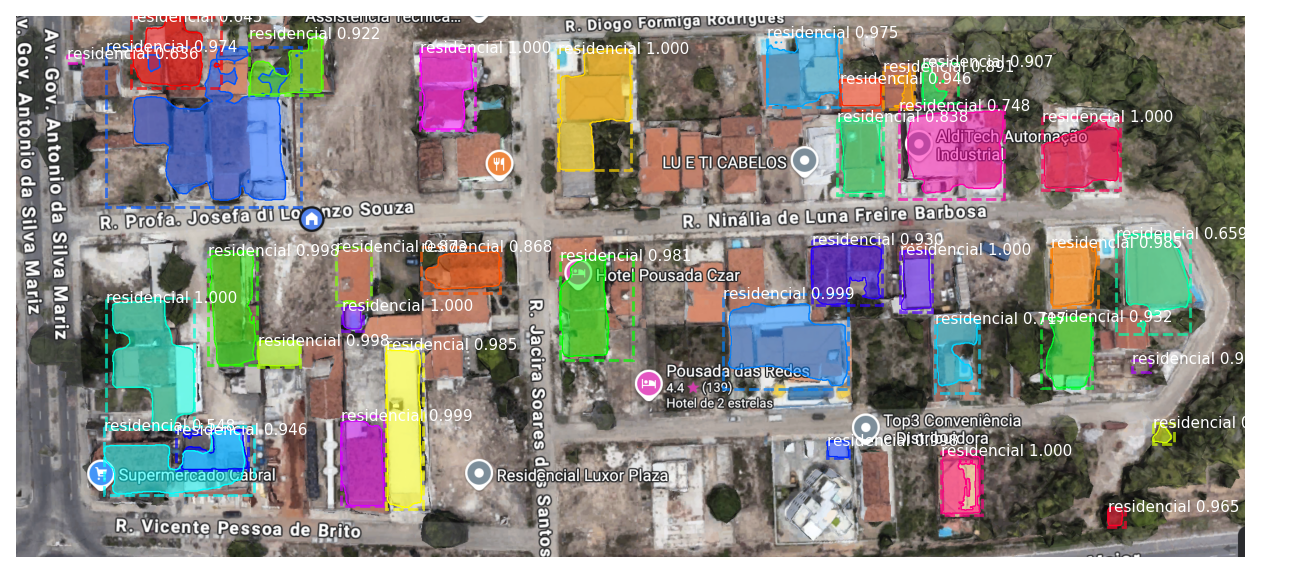

In [16]:
# Run detection
results = model.detect([image], verbose=1)

print(results)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [10]:
import sys
# Calcula o tamanho total da lista em bytes
tamanho_bytes = sys.getsizeof(results)

# Conversão de bytes para MB
tamanho_mb = tamanho_bytes / (1024 * 1024)

print(f"Tamanho da lista em MB: {tamanho_mb}")

Tamanho da lista em MB: 8.392333984375e-05


In [12]:
import json

# Simplificando os resultados para salvar
# Aqui estamos removendo 'masks' para evitar um arquivo grande, mas você poderia adicionar qualquer lógica necessária
# para resumir ou referenciar esses dados de outra forma
simplified_results = {
    "rois": r['rois'].tolist(),  # Converte arrays numpy para listas
    "class_ids": r['class_ids'].tolist(),
    "scores": r['scores'].tolist(),
    # "masks": "Não incluído para reduzir o tamanho do arquivo"  # Exemplo de como você poderia lidar com 'masks'
    "masks_shape": r['masks'].shape if 'masks' in r else None,  # Salve apenas as dimensões da máscara
}

# Salvando os resultados simplificados em um arquivo JSON
with open('prediction_results.json', 'w') as f:
    # Escreve o json de forma compacta sem espaços extras
    json.dump(simplified_results, f, separators=(',', ':'))

print("Previsão salva em 'prediction_results.json'")

Previsão salva em 'prediction_results.json'


Processing 1 images
image                    shape: (491, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/your_email/miniconda/envs/iptu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


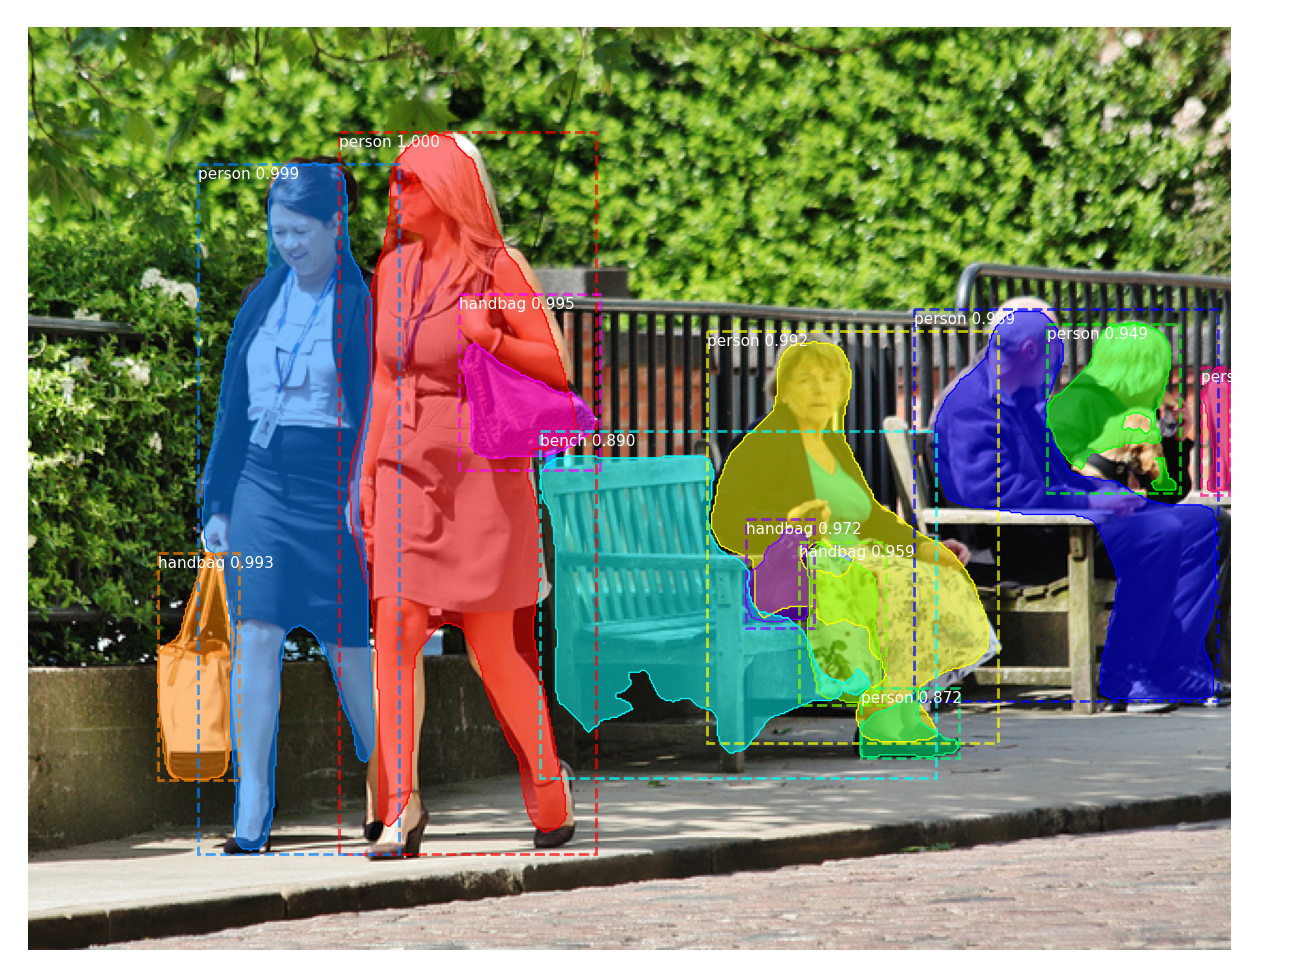

In [11]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])